In [4]:
import pandas as pd

# Function to convert ratings to decimal
def convert_to_decimal(rating):
    rating_str = str(rating)
    if '/' in rating_str:
        numerator, denominator = rating_str.split('/')
        return float(numerator) / float(denominator)
    else:
        try:
            return float(rating_str)
        except ValueError:
            return None  # or some default value if the conversion fails

# Replace 'your_file.csv' with the path to your CSV file
file_path = '/Users/bruno/Documents/Statistical_Analyst_Products/combined_ratings.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Convert 'Review - Overall' to decimal
df['Review - Overall'] = df['Review - Overall'].apply(convert_to_decimal)
# Normalize the 'Review - Overall' values for 'ratebeer' files
df.loc[df['File Name'] == 'ratebeer', 'Review - Overall'] = df['Review - Overall'] / 4

# Convert times and add 'Rating First Digit' column
df['Time'] = pd.to_datetime(df['Review - Time'], unit='s').dt.strftime('%w-%m-%Y')
df['Rating First Digit'] = df['Review - Overall'].astype(str).str[0].astype(int)

# Print the first few rows of the DataFrame to verify the changes
print(df.head())


/var/folders/88/g84kk_9n2498jwvfh8mnxj8w0000gn/T/ipykernel_6542/1785376361.py:19: DtypeWarning: Columns (2,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


   Unnamed: 0                    Name Beer ID  Brewer ID  ABV  \
0           0            Sausa Weizen   47986      10325  5.0   
1           1                Red Moon   48213      10325  6.2   
2           2  Black Horse Black Beer   48215      10325  6.5   
3           3              Sausa Pils   47969      10325  5.0   
4           4           Cauldron DIPA   64883       1075  7.7   

                       Beer Style Review - Appearance Review - Aroma  \
0                      Hefeweizen                 2.5            2.0   
1              English Strong Ale                 3.0            2.5   
2          Foreign / Export Stout                 3.0            2.5   
3                 German Pilsener                 3.5            3.0   
4  American Double / Imperial IPA                 4.0            4.5   

  Review - Palate Review - Taste  Review - Overall  Review - Time  \
0             1.5            1.5               1.5     1234817823   
1             3.0            3.0      

In [5]:
print(df.columns)
df2 = df
print(len(df2))

Index(['Unnamed: 0', 'Name', 'Beer ID', 'Brewer ID', 'ABV', 'Beer Style',
       'Review - Appearance', 'Review - Aroma', 'Review - Palate',
       'Review - Taste', 'Review - Overall', 'Review - Time',
       'Review - Profile Name', 'Review - Text', 'File Name', 'Time',
       'Rating First Digit'],
      dtype='object')
4510777


In [6]:
######################################################## ReviewerID
df2 = df2.rename(columns={'ReviewProfileName': 'ReviewerID'})

In [7]:
######################################################## Time
# its already defined

In [8]:
######################################################## ReviewOverall
df2 = df2.rename(columns={'Review - Overall': 'ReviewOverall'})

In [9]:
######################################################## FileName
df2 = df2.rename(columns={'File Name': 'FileName'})

In [10]:
######################################################## BeerRank
# Convert 'Review - Time' to datetime
df2['Review - Time'] = pd.to_datetime(df2['Review - Time'], unit='s')

# Ensure 'ReviewOverall' is treated as numeric, handling non-numeric values as NaN
df2['ReviewOverall'] = pd.to_numeric(df2['ReviewOverall'], errors='coerce')

# Determine the latest date in your dataset
latest_date = df2['Review - Time'].max()

# Calculate the start of the last month period
start_last_month = latest_date - pd.DateOffset(months=1)

# Filter the DataFrame for reviews in the last month
last_month_reviews = df2[(df2['Review - Time'] > start_last_month) & (df2['Review - Time'] <= latest_date)]

# Calculate the average rating for each beer in the last month
beer_rating_last_month = last_month_reviews.groupby('Beer ID')['ReviewOverall'].mean()

# Rank the beers based on this average rating
beer_rank_last_month = beer_rating_last_month.rank(method='dense', ascending=False).rename('BeerRank')

# Reset index to merge correctly
beer_rating_last_month = beer_rating_last_month.reset_index()

# Merge this ranking back into the original DataFrame
df2 = df2.merge(beer_rank_last_month, on='Beer ID', how='left')

In [11]:
######################################################## BeerRating
import pandas as pd

# Convert 'Review - Time' to datetime
df2['Review - Time'] = pd.to_datetime(df2['Review - Time'], unit='s')

# Ensure that 'ReviewOverall' is treated as numeric, with NaN for non-numeric entries
df2['ReviewOverall'] = pd.to_numeric(df2['ReviewOverall'], errors='coerce')

# Determine the latest date in your dataset
latest_date = df2['Review - Time'].max()

# Calculate the start of the last month period
start_last_month = latest_date - pd.DateOffset(months=1)

# Filter the DataFrame for reviews in the last month
last_month_reviews = df2[(df2['Review - Time'] > start_last_month) & (df2['Review - Time'] <= latest_date)]

# Calculate the average rating for each beer in the last month
beer_rating_last_month = last_month_reviews.groupby('Beer ID')['ReviewOverall'].mean()

# Merge this data back into the original DataFrame
df2 = df2.merge(beer_rating_last_month, on='Beer ID', how='left', suffixes=('', '_LastMonth'))

# Renaming the merged column to 'BeerRating'
df2.rename(columns={'ReviewOverall_LastMonth': 'BeerRating'}, inplace=True)

In [12]:
######################################################## BeerABV
df2 = df2.rename(columns={'ABV': 'BeerABV'})

In [13]:
######################################################## BeerPopularity
# Convert 'Review - Time' to datetime if not already done
df2['Review - Time'] = pd.to_datetime(df2['Review - Time'])

# Find the latest date in your dataset, which will act as the 'current' date
current_date = df2['Review - Time'].max()

# Define the date range for the last month
one_month_ago = current_date - pd.DateOffset(months=1)

# Filter reviews in the last month
last_month_reviews = df2[(df2['Review - Time'] > one_month_ago) & (df2['Review - Time'] <= current_date)]

# Count the number of reviews for each beer in the last month
beer_popularity = last_month_reviews.groupby('Beer ID').size().rename('BeerPopularity')

# Join this count back to the original DataFrame
df2 = df2.join(beer_popularity, on='Beer ID', how='left')

# Replace NaN values with 0 - assuming no reviews means 0 popularity
df2['BeerPopularity'].fillna(0, inplace=True)

In [14]:
######################################################## BrewerRank
# Convert 'Review - Time' to datetime if it's not already
df2['Review - Time'] = pd.to_datetime(df2['Review - Time'], unit='s')

# Determine the latest date in your dataset
latest_date = df2['Review - Time'].max()

# Calculate the start of the last month period
start_last_month = latest_date - pd.DateOffset(months=1)

# Filter the DataFrame for reviews in the last month
last_month_reviews = df2[(df2['Review - Time'] > start_last_month) & (df2['Review - Time'] <= latest_date)]

# Calculate the total number of reviews for each brewer in the last month
brewer_reviews_last_month = last_month_reviews.groupby('Brewer ID').size()

# Rank the brewers based on this total number of reviews
# 'dense' ranking method ensures that brewers with the same number of reviews share the same rank
brewer_rank_last_month = brewer_reviews_last_month.rank(method='dense', ascending=False).rename('BrewerRank')

# Merge this ranking back into the original DataFrame
df2 = df2.merge(brewer_rank_last_month, on='Brewer ID', how='left')

In [15]:
######################################################## BrewerPopularity
# Convert 'Review - Time' to datetime if not already done
df2['Review - Time'] = pd.to_datetime(df2['Review - Time'])

# Find the latest date in your dataset, which will act as the 'current' date
current_date = df2['Review - Time'].max()

# Define the date range for the last month
one_month_ago = current_date - pd.DateOffset(months=1)

# Filter reviews in the last month
last_month_reviews = df2[(df2['Review - Time'] > one_month_ago) & (df2['Review - Time'] <= current_date)]

# Count the number of reviews for each beer in the last month
beer_popularity = last_month_reviews.groupby('Brewer ID').size().rename('BrewerPopularity')

# Join this count back to the original DataFrame
df2 = df2.join(beer_popularity, on='Brewer ID', how='left')

# Replace NaN values with 0 - assuming no reviews means 0 popularity
df2['BrewerPopularity'].fillna(0, inplace=True)

In [16]:
######################################################## ReviewNumber
# Sort your DataFrame by 'Beer ID' and 'Review - Time' to ensure that the reviews are in chronological order.
#Use the cumcount() function grouped by 'Beer ID' to assign a sequential number to each review for each beer.

# Ensure your DataFrame is sorted by 'Beer ID' and 'Review - Time'
df2 = df2.sort_values(by=['Beer ID', 'Review - Time'])

# Create the 'ReviewNumber' column
# cumcount() starts from 0, so we add 1 to start the sequence from 1
df2['ReviewNumber'] = df2.groupby('Beer ID').cumcount() + 1

In [17]:
######################################################## ReviewLength
df2['ReviewLength'] = df2['Review - Text'].astype(str).apply(len)

In [18]:
######################################################## CrowdSize
# Convert 'Review - Time' to datetime if it's not already
df2['Review - Time'] = pd.to_datetime(df2['Review - Time'], unit='s')

# Determine the latest date in your dataset
latest_date = df2['Review - Time'].max()

# Calculate the start of the last month period
start_last_month = latest_date - pd.DateOffset(months=1)

# Filter the DataFrame for reviews in the last month
last_month_reviews = df2[(df2['Review - Time'] > start_last_month) & (df2['Review - Time'] <= latest_date)]

# Calculate the total number of reviews for each beer style/category in the last month
crowd_size_last_month = last_month_reviews.groupby('Beer Style').size().rename('CrowdSize')

# Merge this count back into the original DataFrame
df2 = df2.merge(crowd_size_last_month, on='Beer Style', how='left')


In [19]:
######################################################## ReviewerTenure
# Convert 'Review - Time' from Unix timestamp to datetime
df2['Review - Time'] = pd.to_datetime(df2['Review - Time'], unit='s')

# Calculate the earliest review date for each reviewer
# Replace 'ReviewerID' with the column that uniquely identifies each reviewer in your DataFrame
earliest_review = df2.groupby('Review - Profile Name')['Review - Time'].min()

# Map the earliest review date to each row in the DataFrame
df2['EarliestReview'] = df2['Review - Profile Name'].map(earliest_review)

# Calculate the tenure as the difference between the review date and the earliest review date
df2['ReviewerTenure'] = df2['Review - Time'] - df2['EarliestReview']

# Convert tenure to the number of days
df2['ReviewerTenure'] = df2['ReviewerTenure'].dt.days

In [20]:
######################################################## ReviewerExperience
# Ensure your DataFrame is sorted by reviewer ID and review time
df2 = df2.sort_values(by=['Review - Profile Name', 'Review - Time'])

# Create the 'ReviewerExperience' column
# cumcount() starts from 0, so we add 1 to start the count from 1
df2['ReviewerExperience'] = df2.groupby('Review - Profile Name').cumcount() + 1

**TABLE 1**

In [23]:
import pandas as pd
from scipy import stats

# List of variables for the analysis
variables = ['ReviewOverall', 'BeerRank', 'BeerRating', 'BeerPopularity', 'BrewerRank', 'BeerABV',
             'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']

# Remove any non-numeric characters from 'BeerABV' (e.g., '%')
df2['BeerABV'] = df2['BeerABV'].replace('[^0-9.]', '', regex=True)
# Convert 'BeerABV' to numeric, setting errors='coerce' to turn non-convertible values into NaN
df2['BeerABV'] = pd.to_numeric(df2['BeerABV'], errors='coerce')

# Splitting the dataset specifically for 'beeradvocate' and 'ratebeer'
df_platform1 = df2[df2['FileName'] == 'beeradvocate']
df_platform2 = df2[df2['FileName'] == 'ratebeer']

# Prepare a list to collect rows for Table 1
table1_data = []

# Total number of variables
total_variables = len(variables)
current_variable = 0

# Iterate over each variable to calculate and print the statistics
for var in variables:
    current_variable += 1
    print(f"Processing variable {current_variable} of {total_variables}: {var}")

    # Calculating means and standard deviations
    mean1 = df_platform1[var].mean()
    sd1 = df_platform1[var].std()
    mean2 = df_platform2[var].mean()
    sd2 = df_platform2[var].std()
    print("  Calculated means and standard deviations.")

    # Perform t-test
    t_test_result = stats.ttest_ind(df_platform1[var].dropna(), df_platform2[var].dropna(), equal_var=False)
    print(f"  Performed t-test. T-statistic: {t_test_result.statistic:.10f}")

    # Add the results to the table data
    row = {
        'Variable': var, 
        'Mean_beeradvocate': mean1, 
        'SD_beeradvocate': sd1, 
        'Mean_ratebeer': mean2, 
        'SD_ratebeer': sd2, 
        'T-Statistic': f"{t_test_result.statistic:.10f}"
    }
    table1_data.append(row)
    print("  Finished processing.")

# Create DataFrame from the list
table1 = pd.DataFrame(table1_data)

# Displaying the final Table 1
print("\nCompleted all calculations. Displaying Table 1:")
table1


Processing variable 1 of 12: ReviewOverall
  Calculated means and standard deviations.
  Performed t-test. T-statistic: 6375.1811664091
  Finished processing.
Processing variable 2 of 12: BeerRank
  Calculated means and standard deviations.
  Performed t-test. T-statistic: -2396.6562599764
  Finished processing.
Processing variable 3 of 12: BeerRating
  Calculated means and standard deviations.
  Performed t-test. T-statistic: 2600.6789951493
  Finished processing.
Processing variable 4 of 12: BeerPopularity
  Calculated means and standard deviations.
  Performed t-test. T-statistic: 220.6620681993
  Finished processing.
Processing variable 5 of 12: BrewerRank
  Calculated means and standard deviations.
  Performed t-test. T-statistic: -193.5249334958
  Finished processing.
Processing variable 6 of 12: BeerABV
  Calculated means and standard deviations.
  Performed t-test. T-statistic: 171.6554055482
  Finished processing.
Processing variable 7 of 12: BrewerPopularity
  Calculated mean

,Variable,Mean_beeradvocate,SD_beeradvocate,Mean_ratebeer,SD_ratebeer,T-Statistic
0,ReviewOverall,3.815581,0.720622,0.164996,0.041907,6375.1811664091
1,BeerRank,265.615989,250.954837,1018.786745,284.381508,-2396.6562599764
2,BeerRating,3.474004,1.020433,0.478296,0.878167,2600.6789951493
3,BeerPopularity,7.011506,11.122742,4.820897,7.757442,220.6620681993
4,BrewerRank,105.500490,68.370963,118.736237,65.971992,-193.5249334958
5,BeerABV,7.042387,2.322526,6.640794,2.313753,171.6554055482
6,BrewerPopularity,146.672266,173.496381,113.014094,147.135028,207.2489633609
7,ReviewNumber,319.570206,472.616903,266.134632,430.192288,118.2879518057
8,ReviewLength,695.010994,377.965479,307.886899,215.019847,1189.8824761055
9,CrowdSize,658.057147,593.740888,991.607643,745.857354,-519.3534361655


In [45]:
######################################################## MODEL1 - check  correlation matrix before

import pandas as pd

# Assuming df2 is your DataFrame and it has been appropriately cleaned and pre-processed

# Computing the correlation matrix
corr_matrix = df2[['BeerRank', 'BeerABV', 'BeerPopularity', 'BrewerRank', 
                   'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
                   'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']].corr()

# Define a high correlation threshold
high_corr_threshold = 0.8

# Identifying pairs of highly correlated variables
highly_correlated_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            highly_correlated_pairs.append((colname_i, colname_j, corr_matrix.iloc[i, j]))

# Converting the list of pairs to a DataFrame for better readability
high_corr_pairs_df = pd.DataFrame(highly_correlated_pairs, columns=['Variable 1', 'Variable 2', 'Correlation'])

print(high_corr_pairs_df)

         Variable 1  Variable 2  Correlation
0  BrewerPopularity  BrewerRank    -0.857181


**TABLE 2**

                            OLS Regression Results                            
Dep. Variable:             BeerRating   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 2.083e+05
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:42:03   Log-Likelihood:            -1.7916e+06
No. Observations:             2937805   AIC:                         3.583e+06
Df Residuals:                 2937795   BIC:                         3.583e+06
Df Model:                           9                                         
Covariance Type:              cluster                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.6226      0

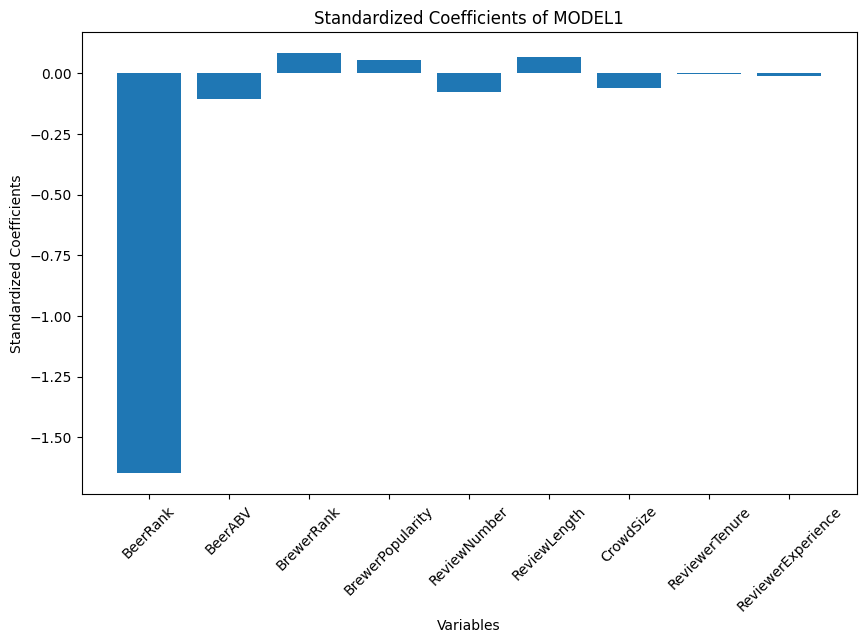

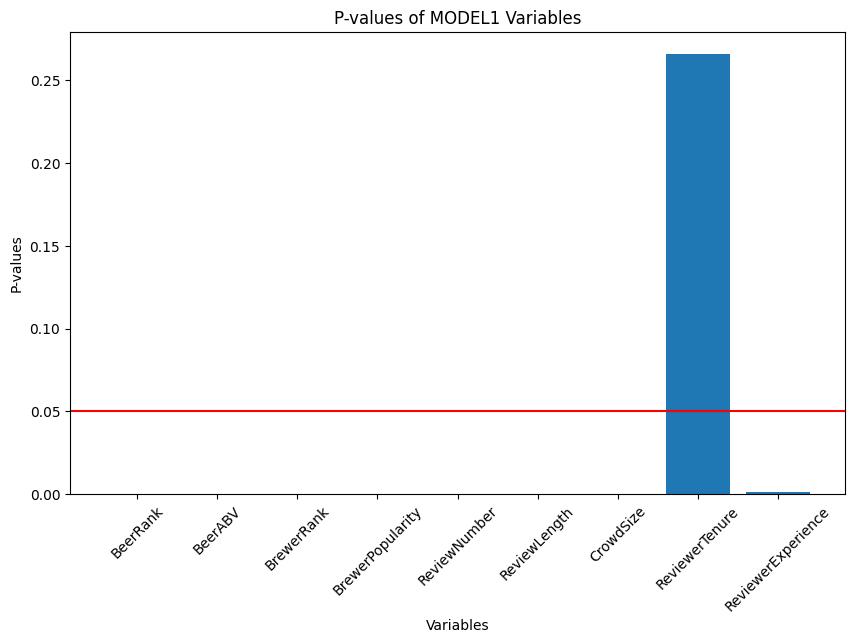

In [68]:
######################################################## MODEL1 removing 'BeerPopularity'

import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# Check and convert data types if necessary
# Ensure all control variables are numeric
for column in ['BeerRank', 'BeerABV', 'BrewerRank', 
               'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
               'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']:
    df2[column] = pd.to_numeric(df2[column], errors='coerce')

# Handling missing values
df2 = df2.dropna(subset=['BeerRating', 'BeerRank', 'BeerABV', 
                         'BrewerRank', 'BrewerPopularity', 'ReviewNumber', 
                         'ReviewLength', 'CrowdSize', 'ReviewerTenure', 
                         'ReviewerExperience'])

# Define the dependent variable
y = df2['BeerRating']

# Define the independent variables (excluding 'BeerPopularity')
X = df2[['BeerRank', 'BeerABV', 'BrewerRank', 
         'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
         'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']]

# Standardizing the variables manually
X_standardized = (X - X.mean()) / X.std()

# Add a constant to the model (intercept)
X_standardized = sm.add_constant(X_standardized)

# Define the dependent variable
y = df2['BeerRating']

# Assuming you have a column in df2 that uniquely identifies each user (e.g., 'UserID')
clusters = df2['Review - Profile Name']

# Fit the regression model with clustered standard errors
model = sm.OLS(y, X_standardized).fit(cov_type='cluster', cov_kwds={'groups': clusters})

# Print out the regression results
print(model.summary())

# Plotting the standardized coefficients
plt.figure(figsize=(10, 6))
model_params = model.params.drop('const')  # Drop the constant for the plot
plt.bar(model_params.index, model_params.values)
plt.xlabel('Variables')
plt.ylabel('Standardized Coefficients')
plt.title('Standardized Coefficients of MODEL1')
plt.xticks(rotation=45)
plt.show()

# Plotting the p-values
plt.figure(figsize=(10, 6))
model_pvalues = model.pvalues.drop('const')  # Drop the constant for the plot
plt.bar(model_pvalues.index, model_pvalues.values)
plt.xlabel('Variables')
plt.ylabel('P-values')
plt.title('P-values of MODEL1 Variables')
plt.xticks(rotation=45)
plt.axhline(y=0.05, color='r', linestyle='-')  # Line for p-value threshold (e.g., 0.05)
plt.show()

                            OLS Regression Results                            
Dep. Variable:         FileName_Dummy   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 1.449e+04
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:43:12   Log-Likelihood:            -1.3378e+05
No. Observations:             2937805   AIC:                         2.676e+05
Df Residuals:                 2937795   BIC:                         2.677e+05
Df Model:                           9                                         
Covariance Type:              cluster                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3836      0

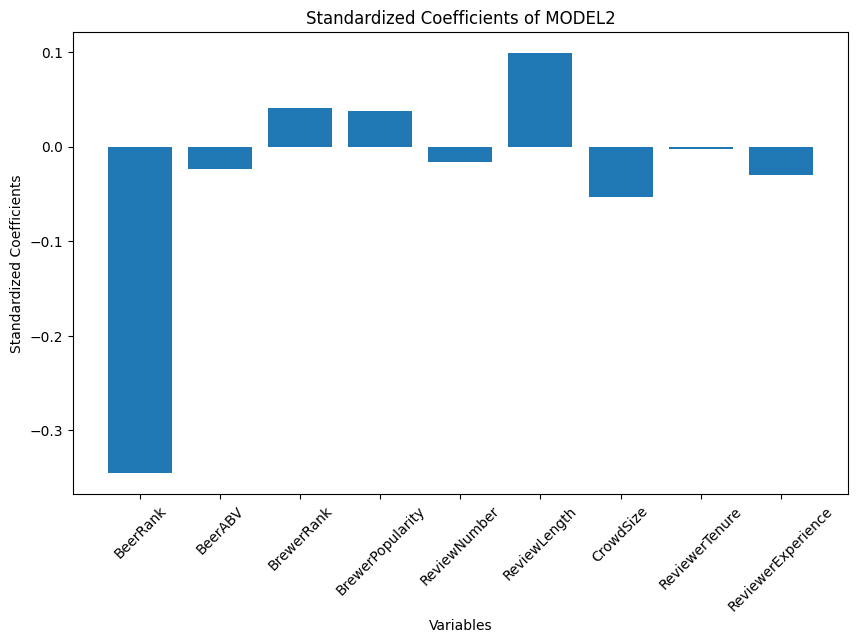

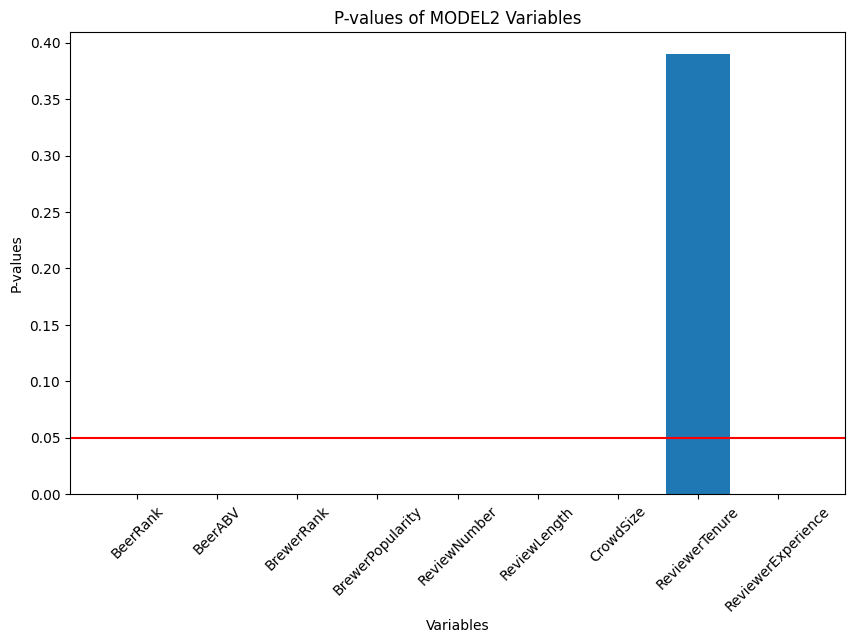

In [69]:
######################################################## MODEL2 -- removing 'BeerPopularity'

import statsmodels.api as sm
import pandas as pd

# Convert 'FileName' to a dummy variable
# Representing "ratebeer" as 0 and "beeradvocate" as 1
df2['FileName_Dummy'] = df2['FileName'].map({'ratebeer': 0, 'beeradvocate': 1})

# Check and convert other data types if necessary
# Ensure all control variables are numeric
for column in ['BeerRank', 'BeerABV', 'BeerPopularity', 'BrewerRank', 
               'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
               'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']:
    df2[column] = pd.to_numeric(df2[column], errors='coerce')

# Handling missing values for the new model
df2 = df2.dropna(subset=['FileName_Dummy', 'BeerRank', 'BeerABV', 'BeerPopularity', 
                         'BrewerRank', 'BrewerPopularity', 'ReviewNumber', 
                         'ReviewLength', 'CrowdSize', 'ReviewerTenure', 
                         'ReviewerExperience'])

# Define the new dependent variable
y = df2['FileName_Dummy']

# Define the independent variables (control variables remain the same)
X = df2[['BeerRank', 'BeerABV', 'BrewerRank', 
         'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
         'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']]

# Standardizing the variables manually
X_standardized = (X - X.mean()) / X.std()

# Add a constant to the model (intercept)
X_standardized = sm.add_constant(X_standardized)

# Assuming 'Review - Profile Name' is the column that uniquely identifies each user
clusters = df2['Review - Profile Name']

# Fit the new regression model with clustered standard errors
model2 = sm.OLS(y, X_standardized).fit(cov_type='cluster', cov_kwds={'groups': clusters})

# Print out the regression results
print(model2.summary())

# Plotting the standardized coefficients
plt.figure(figsize=(10, 6))
model2_params = model2.params.drop('const')  # Drop the constant for the plot
plt.bar(model2_params.index, model2_params.values)
plt.xlabel('Variables')
plt.ylabel('Standardized Coefficients')
plt.title('Standardized Coefficients of MODEL2')
plt.xticks(rotation=45)
plt.show()

# Plotting the p-values
plt.figure(figsize=(10, 6))
model2_pvalues = model2.pvalues.drop('const')  # Drop the constant for the plot
plt.bar(model2_pvalues.index, model2_pvalues.values)
plt.xlabel('Variables')
plt.ylabel('P-values')
plt.title('P-values of MODEL2 Variables')
plt.xticks(rotation=45)
plt.axhline(y=0.05, color='r', linestyle='-')  # Line for p-value threshold (e.g., 0.05)
plt.show()

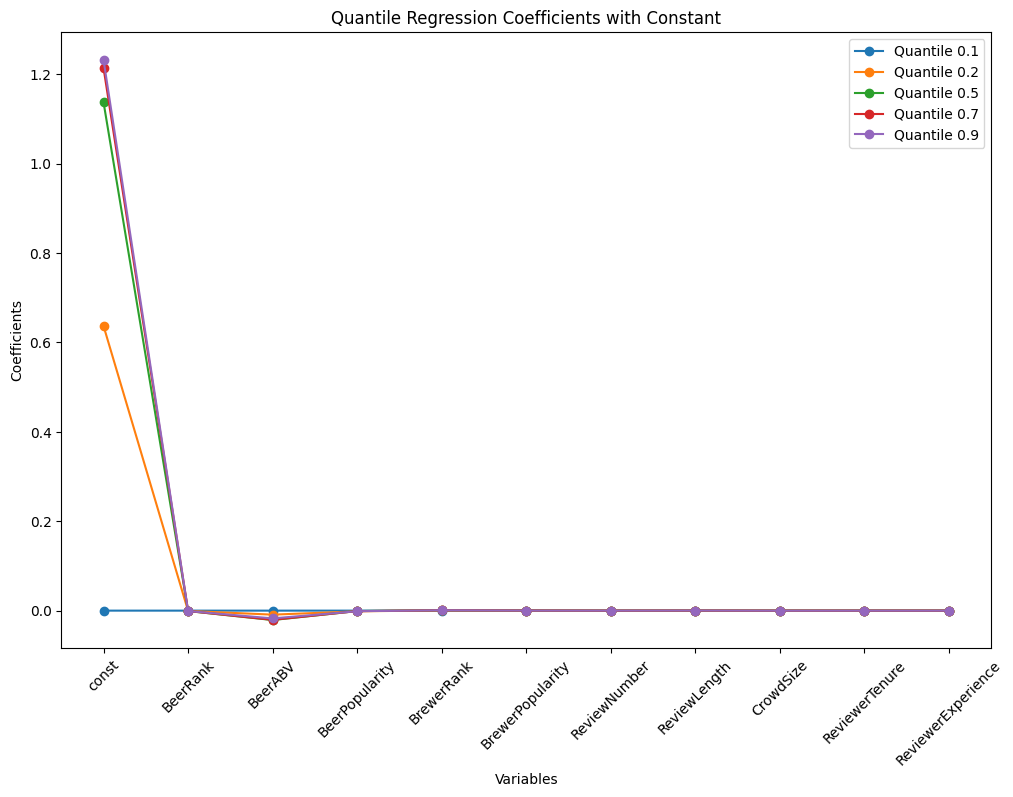

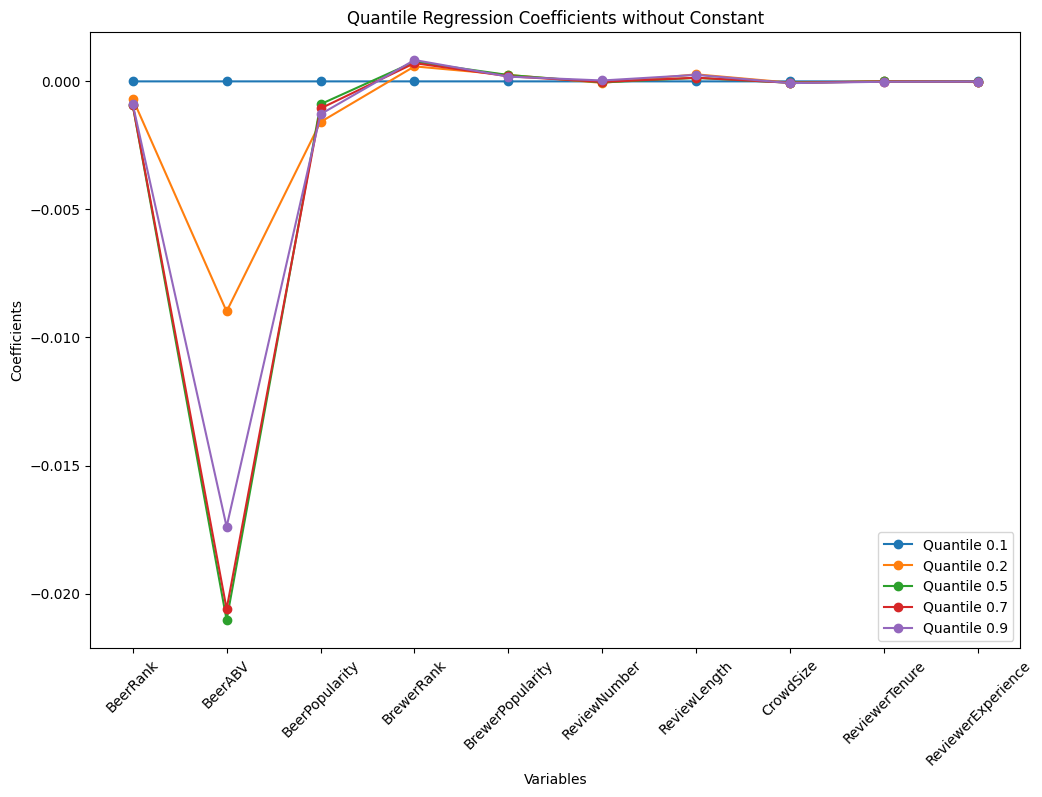

In [64]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'FileName' to a dummy variable
# Representing "ratebeer" as 0 and "beeradvocate" as 1
df2['FileName_Dummy'] = df2['FileName'].map({'ratebeer': 0, 'beeradvocate': 1})

# Check and convert other data types if necessary
# Ensure all control variables are numeric
for column in ['BeerRank', 'BeerABV', 'BeerPopularity', 'BrewerRank', 
               'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
               'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']:
    df2[column] = pd.to_numeric(df2[column], errors='coerce')

# Handling missing values for the new model
df2 = df2.dropna(subset=['FileName_Dummy', 'BeerRank', 'BeerABV', 'BeerPopularity', 
                         'BrewerRank', 'BrewerPopularity', 'ReviewNumber', 
                         'ReviewLength', 'CrowdSize', 'ReviewerTenure', 
                         'ReviewerExperience'])

# Define the new dependent variable
y = df2['FileName_Dummy']

# Define the independent variables
X = df2[['BeerRank', 'BeerABV', 'BeerPopularity', 'BrewerRank', 
         'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
         'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Perform quantile regressions
quantiles = [0.10, 0.20, 0.50, 0.70, 0.90]
models = []
for q in quantiles:
    quantile_model = sm.QuantReg(y, X).fit(q=q, max_iter=1000)  # Increase max_iter
    models.append(quantile_model)

# Plotting with constant
plt.figure(figsize=(12, 8))
for i, model in enumerate(models):
    plt.plot(model.params.index, model.params.values, marker='o', label=f'Quantile {quantiles[i]}')
plt.xlabel('Variables')
plt.ylabel('Coefficients')
plt.title('Quantile Regression Coefficients with Constant')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plotting without constant
plt.figure(figsize=(12, 8))
for i, model in enumerate(models):
    # Exclude the constant from plotting
    params = model.params.drop('const')
    plt.plot(params.index, params.values, marker='o', label=f'Quantile {quantiles[i]}')
plt.xlabel('Variables')
plt.ylabel('Coefficients')
plt.title('Quantile Regression Coefficients without Constant')
plt.xticks(rotation=45)
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:             BeerRating   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                 4.422e+05
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:38:19   Log-Likelihood:            -1.5563e+06
No. Observations:             2937805   AIC:                         3.113e+06
Df Residuals:                 2937794   BIC:                         3.113e+06
Df Model:                          10                                         
Covariance Type:              cluster                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

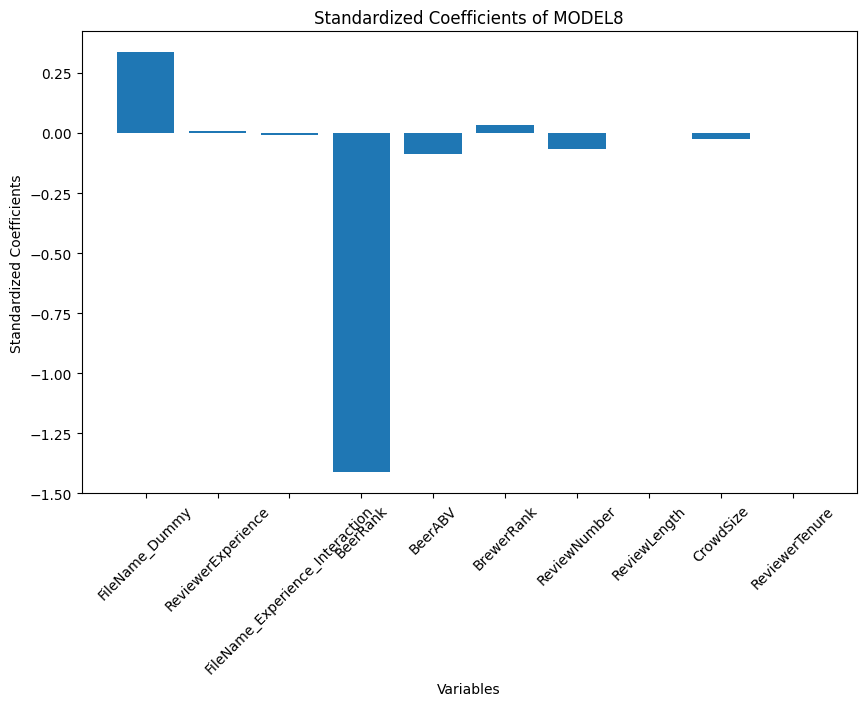

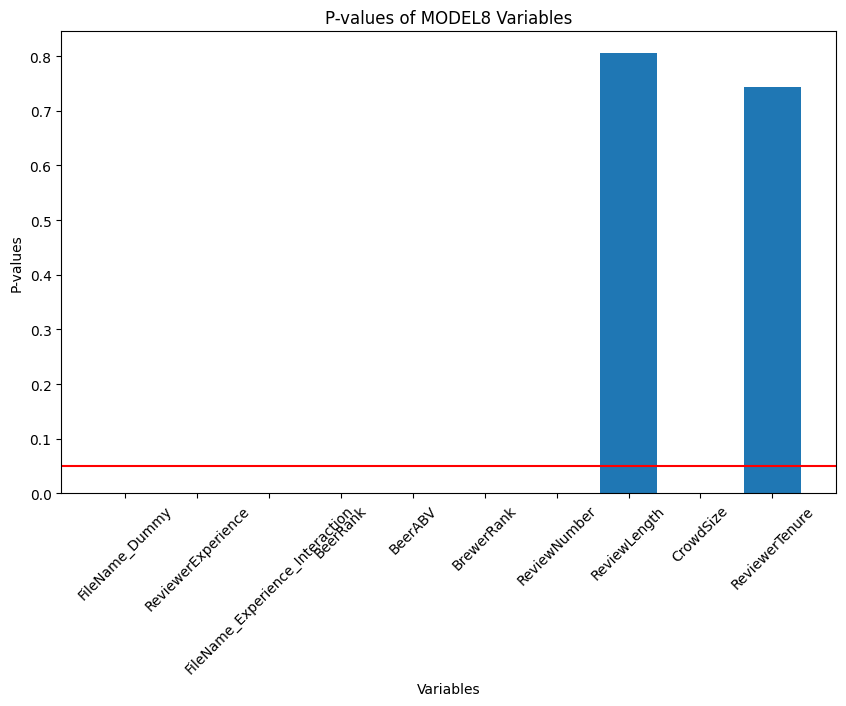

In [65]:
######################################################## MODEL8 -- removing 'BeerPopularity'
import statsmodels.api as sm
import pandas as pd

# Convert 'FileName' to a dummy variable
# Representing "ratebeer" as 0 and "beeradvocate" as 1
df2['FileName_Dummy'] = df2['FileName'].map({'ratebeer': 0, 'beeradvocate': 1})

# Check and convert other data types if necessary
# Ensure all control variables are numeric
for column in ['BeerRank', 'BeerABV', 'BeerPopularity', 'BrewerRank', 
               'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
               'CrowdSize', 'ReviewerTenure', 'ReviewerExperience', 'BeerRating']:
    df2[column] = pd.to_numeric(df2[column], errors='coerce')

# Handling missing values
df2 = df2.dropna(subset=['FileName_Dummy', 'ReviewerExperience', 'BeerRating',
                         'BeerRank', 'BeerABV', 'BeerPopularity', 'BrewerRank', 
                         'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
                         'CrowdSize', 'ReviewerTenure'])

# Create the interaction term
df2['FileName_Experience_Interaction'] = df2['FileName_Dummy'] * df2['ReviewerExperience']

# Define the independent variables
X = df2[['FileName_Dummy', 'ReviewerExperience', 'FileName_Experience_Interaction', 
         'BeerRank', 'BeerABV', 'BrewerRank', 
         'ReviewNumber', 'ReviewLength', 'CrowdSize', 'ReviewerTenure']]

# Define the dependent variable
y = df2['BeerRating']

# Standardizing the variables manually
X_standardized = (X - X.mean()) / X.std()

# Add a constant to the model (intercept)
X_standardized = sm.add_constant(X_standardized)

# Assuming you have a column in df2 that uniquely identifies each user (e.g., 'UserID')
clusters = df2['Review - Profile Name']

# Fit the regression model with clustered standard errors
model8 = sm.OLS(y, X_standardized).fit(cov_type='cluster', cov_kwds={'groups': clusters})

# Print out the regression results
print(model8.summary())

# Plotting the standardized coefficients
plt.figure(figsize=(10, 6))
model8_params = model8.params.drop('const')  # Drop the constant for the plot
plt.bar(model8_params.index, model8_params.values)
plt.xlabel('Variables')
plt.ylabel('Standardized Coefficients')
plt.title('Standardized Coefficients of MODEL8')
plt.xticks(rotation=45)
plt.show()

# If you also want to plot the p-values to see the significance
plt.figure(figsize=(10, 6))
model8_pvalues = model8.pvalues.drop('const')  # Drop the constant for the plot
plt.bar(model8_pvalues.index, model8_pvalues.values)
plt.xlabel('Variables')
plt.ylabel('P-values')
plt.title('P-values of MODEL8 Variables')
plt.xticks(rotation=45)
plt.axhline(y=0.05, color='r', linestyle='-')  # Line for p-value threshold (e.g., 0.05)
plt.show()

                            OLS Regression Results                            
Dep. Variable:           ReviewLength   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     872.1
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:39:32   Log-Likelihood:            -2.0806e+07
No. Observations:             2937805   AIC:                         4.161e+07
Df Residuals:                 2937794   BIC:                         4.161e+07
Df Model:                          10                                         
Covariance Type:              cluster                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

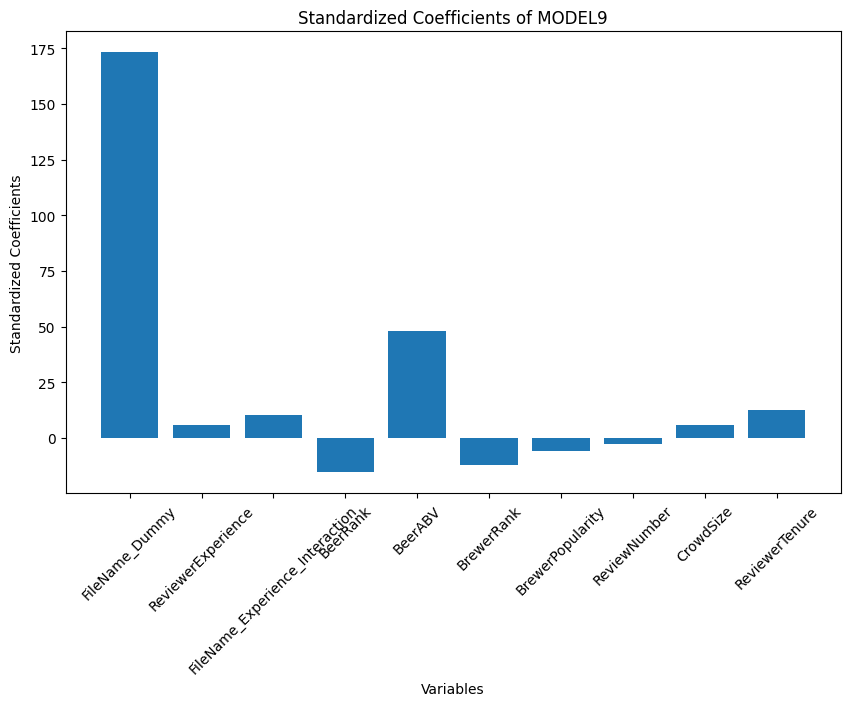

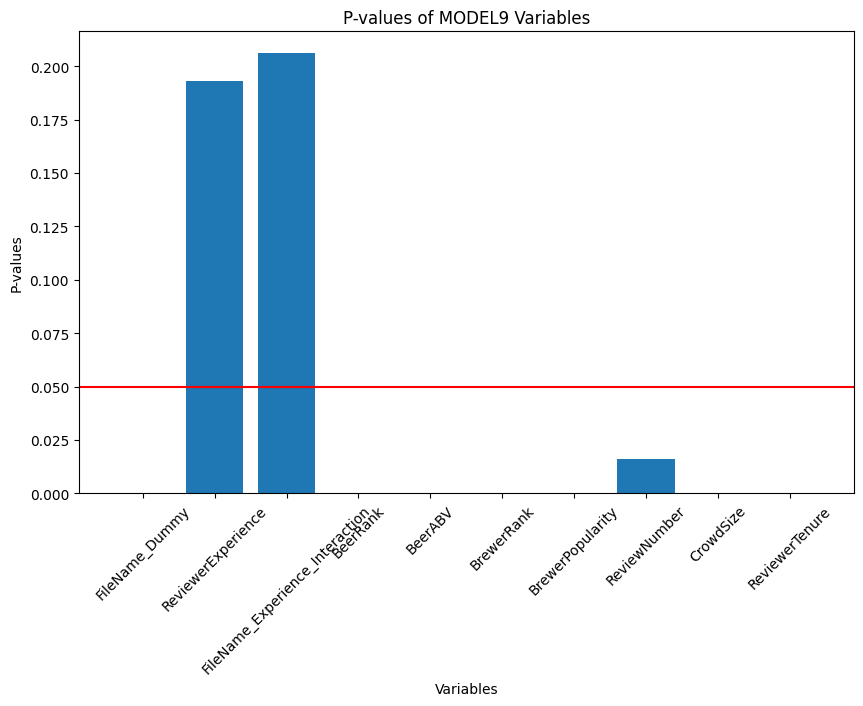

In [66]:
######################################################## MODEL9 -- removing 'BeerPopularity'

import statsmodels.api as sm
import pandas as pd

# Assuming df2 is your DataFrame
# Also assuming 'FileName' contains categories like 'ratebeer' and 'beeradvocate'

# Convert 'FileName' to a dummy variable
# Representing "ratebeer" as 0 and "beeradvocate" as 1
df2['FileName_Dummy'] = df2['FileName'].map({'ratebeer': 0, 'beeradvocate': 1})

# Check and convert other data types if necessary
# Ensure all control variables are numeric
for column in ['BeerRank', 'BeerABV', 'BeerPopularity', 'BrewerRank', 
               'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
               'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']:
    df2[column] = pd.to_numeric(df2[column], errors='coerce')

# Handling missing values
df2 = df2.dropna(subset=['FileName_Dummy', 'ReviewerExperience', 'ReviewLength',
                         'BeerRank', 'BeerABV', 'BeerPopularity', 'BrewerRank', 
                         'BrewerPopularity', 'ReviewNumber', 'CrowdSize', 'ReviewerTenure'])

# Create the interaction term
df2['FileName_Experience_Interaction'] = df2['FileName_Dummy'] * df2['ReviewerExperience']

# Define the independent variables
X = df2[['FileName_Dummy', 'ReviewerExperience', 'FileName_Experience_Interaction', 
         'BeerRank', 'BeerABV', 'BrewerRank', 'BrewerPopularity', 
         'ReviewNumber', 'CrowdSize', 'ReviewerTenure']]

# Define the dependent variable
y = df2['ReviewLength']

# Standardizing the variables manually
X_standardized = (X - X.mean()) / X.std()

# Add a constant to the model (intercept)
X_standardized = sm.add_constant(X_standardized)

# Assuming you have a column in df2 that uniquely identifies each user (e.g., 'UserID')
clusters = df2['Review - Profile Name']

# Fit the regression model with clustered standard errors
model9 = sm.OLS(y, X_standardized).fit(cov_type='cluster', cov_kwds={'groups': clusters})

# Print out the regression results
print(model9.summary())

# Plotting the standardized coefficients
plt.figure(figsize=(10, 6))
model9_params = model9.params.drop('const')  # Drop the constant for the plot
plt.bar(model9_params.index, model9_params.values)
plt.xlabel('Variables')
plt.ylabel('Standardized Coefficients')
plt.title('Standardized Coefficients of MODEL9')
plt.xticks(rotation=45)
plt.show()

# Plotting the p-values
plt.figure(figsize=(10, 6))
model9_pvalues = model9.pvalues.drop('const')  # Drop the constant for the plot
plt.bar(model9_pvalues.index, model9_pvalues.values)
plt.xlabel('Variables')
plt.ylabel('P-values')
plt.title('P-values of MODEL9 Variables')
plt.xticks(rotation=45)
plt.axhline(y=0.05, color='r', linestyle='-')  # Line for p-value threshold (e.g., 0.05)
plt.show()

                            OLS Regression Results                            
Dep. Variable:               BeerRank   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.738e+27
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:40:36   Log-Likelihood:             5.7995e+07
No. Observations:             2937805   AIC:                        -1.160e+08
Df Residuals:                 2937794   BIC:                        -1.160e+08
Df Model:                          10                                         
Covariance Type:              cluster                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

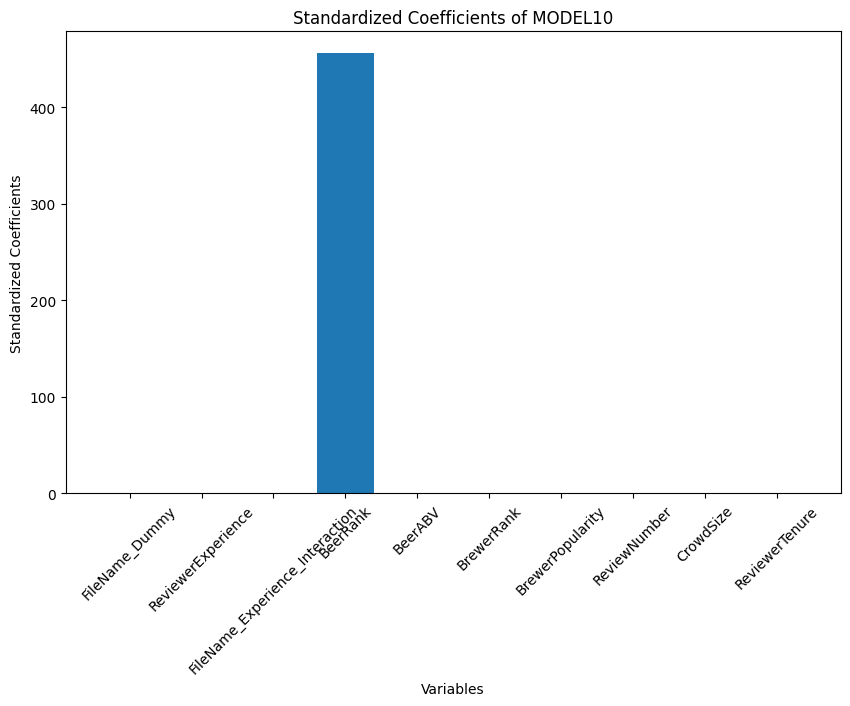

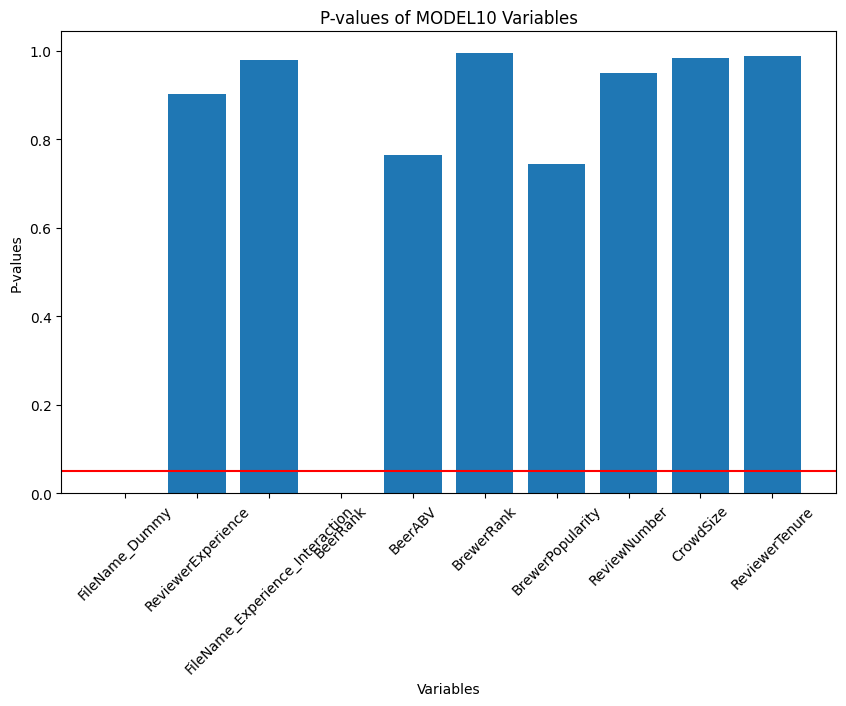

In [67]:
######################################################## MODEL10 -- removing 'BeerPopularity'

import statsmodels.api as sm
import pandas as pd

# Convert 'FileName' to a dummy variable
# Representing "ratebeer" as 0 and "beeradvocate" as 1
df2['FileName_Dummy'] = df2['FileName'].map({'ratebeer': 0, 'beeradvocate': 1})

# Check and convert other data types if necessary
# Ensure all control variables are numeric
for column in ['BeerRank', 'BeerABV', 'BeerPopularity', 'BrewerRank', 
               'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
               'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']:
    df2[column] = pd.to_numeric(df2[column], errors='coerce')

# Handling missing values
df2 = df2.dropna(subset=['FileName_Dummy', 'ReviewerExperience', 'ReviewLength',
                         'BeerRank', 'BeerABV', 'BeerPopularity', 'BrewerRank', 
                         'BrewerPopularity', 'ReviewNumber', 'CrowdSize', 'ReviewerTenure'])

# Create the interaction term
df2['FileName_Experience_Interaction'] = df2['FileName_Dummy'] * df2['ReviewerExperience']

# Define the independent variables
X = df2[['FileName_Dummy', 'ReviewerExperience', 'FileName_Experience_Interaction', 
         'BeerRank', 'BeerABV', 'BrewerRank', 'BrewerPopularity', 
         'ReviewNumber', 'CrowdSize', 'ReviewerTenure']]

# Define the dependent variable (replace 'ReviewLength' with 'BeerRank')
y = df2['BeerRank']

# Standardizing the variables manually
X_standardized = (X - X.mean()) / X.std()

# Add a constant to the model (intercept)
X_standardized = sm.add_constant(X_standardized)

# Assuming you have a column in df2 that uniquely identifies each user (e.g., 'UserID')
clusters = df2['Review - Profile Name']

# Fit the regression model with clustered standard errors
model10 = sm.OLS(y, X_standardized).fit(cov_type='cluster', cov_kwds={'groups': clusters})

# Print out the regression results
print(model10.summary())

# Plotting the standardized coefficients
plt.figure(figsize=(10, 6))
model10_params = model10.params.drop('const')  # Drop the constant for the plot
plt.bar(model10_params.index, model10_params.values)
plt.xlabel('Variables')
plt.ylabel('Standardized Coefficients')
plt.title('Standardized Coefficients of MODEL10')
plt.xticks(rotation=45)
plt.show()

# Plotting the p-values
plt.figure(figsize=(10, 6))
model10_pvalues = model10.pvalues.drop('const')  # Drop the constant for the plot
plt.bar(model10_pvalues.index, model10_pvalues.values)
plt.xlabel('Variables')
plt.ylabel('P-values')
plt.title('P-values of MODEL10 Variables')
plt.xticks(rotation=45)
plt.axhline(y=0.05, color='r', linestyle='-')  # Line for p-value threshold (e.g., 0.05)
plt.show()

In [ ]:
############### MODEL 1 PSM

import pandas as pd
from sklearn.linear_model import LogisticRegression
from causalml.match import NearestNeighborMatch
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 1: Convert 'FileName' to a dummy variable
df2['FileName_Dummy'] = df2['FileName'].map({'ratebeer': 0, 'beeradvocate': 1})

# Step 2: Check and convert data types if necessary
for column in ['BeerRank', 'BeerABV', 'BrewerRank', 'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
               'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']:
    df2[column] = pd.to_numeric(df2[column], errors='coerce')

# Step 3: Handling missing values
df2 = df2.dropna(subset=['BeerRating', 'BeerRank', 'BeerABV', 'BrewerRank', 'BrewerPopularity', 
                         'ReviewNumber', 'ReviewLength', 'CrowdSize', 'ReviewerTenure', 'ReviewerExperience'])

# Step 4: Calculate propensity scores
logit = LogisticRegression()
X_covariates = df2[['BeerRank', 'BeerABV', 'BrewerRank', 'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
                    'CrowdSize', 'ReviewerTenure', 'ReviewerExperience']]  # Add other covariates as needed
y_groups = df2['FileName_Dummy']

logit.fit(X_covariates, y_groups)
propensity_scores = logit.predict_proba(X_covariates)[:, 1]

df2['propensity_score'] = propensity_scores

# Step 5: Perform matching
nnm = NearestNeighborMatch(replace=False, ratio=1, random_state=123)
matched_df = nnm.match(data=df2, treatment_col='FileName_Dummy', score_cols='propensity_score')

# Step 6: Prepare data for fixed effects regression
# Replace 'TimeVariable' with your actual time variable name
matched_df = matched_df.set_index(['Review - Profile Name', 'TimeVariable'])  

# Step 7: Define the dependent and independent variables
y = matched_df['BeerRating']
X = matched_df[['BeerRank', 'BeerABV', 'BrewerRank', 'BrewerPopularity', 'ReviewNumber', 'ReviewLength', 
                'CrowdSize', 'ReviewerTenure', 'ReviewerExperience', 'FileName_Dummy']]

# Standardizing the variables manually
X_standardized = (X - X.mean()) / X.std()

# Add a constant to the model (intercept)
X_standardized = sm.add_constant(X_standardized)

# Step 8: Fit the panel regression model with individual and time fixed effects
model = PanelOLS(y, X_standardized, entity_effects=True, time_effects=True).fit()

# Print out the regression results
print(model.summary)

# Step 9: Plotting the coefficients
plt.figure(figsize=(10, 6))
model_params = model.params.drop('const')  # Drop the constant for the plot
plt.bar(model_params.index, model_params.values)
plt.xlabel('Variables')
plt.ylabel('Coefficients')
plt.title('Coefficients of MODEL1 with Matched Sample')
plt.xticks(rotation=45)
plt.show()